# Deformable Models

William Liaw

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
from IPython.display import HTML
from matplotlib import animation, rc
from skimage import data
from skimage.color import rgb2gray
from skimage.filters import gaussian

# For some image filtering
from skimage.morphology import black_tophat, disk, white_tophat

# For active_contour function
from skimage.segmentation import (
    active_contour,
    chan_vese,
    checkerboard_level_set,
    morphological_chan_vese,
    morphological_geodesic_active_contour,
)

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
def edge_map(img, sigma):
    blur = skimage.filters.gaussian(img, sigma)
    return skimage.filters.sobel(blur)


def edge_map2(img, sigma):
    blur = skimage.filters.gaussian(img, sigma)
    return skimage.filters.scharr(blur)


def subtract_background(image, radius=5, light_bg=False):
    str_el = disk(radius)
    if light_bg:
        return black_tophat(image, str_el)
    else:
        return white_tophat(image, str_el)


def define_initial_circle(R0, r0, c0, Nber_pts=400):
    """Define initial contour shape"""
    s = np.linspace(0, 2 * np.pi, Nber_pts)
    Radius = R0
    r = r0 + Radius * np.sin(s)
    c = c0 + Radius * np.cos(s)  # col
    init = np.array([r, c]).T
    return init


def animate_cv(image, segs, interval=1000):
    """Create slides for animation"""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap="gray")
    im = ax.imshow(segs[0], alpha=0.5, cmap="inferno")
    ax.axis("off")

    def init():
        im.set_data(segs[0])
        return [im]

    def animate(i):
        im.set_array(segs[i])
        return [im]

    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=len(segs), interval=1000, blit=True
    )
    return anim


def animate_snake(image, segs, interval=500):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap="gray")
    #    im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    # ax.plot(segs[0][:, 1], segs[0][:, 0], '--r', lw=3)
    ax.axis("off")
    (line,) = ax.plot([], [], "-r", lw=2)

    def init():
        line.set_data(segs[0, :, 1], segs[0, :, 0])
        return [
            line,
        ]

    def animate(i):
        line.set_data(segs[i, :, 1], segs[i, :, 0])
        return [
            line,
        ]

    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=len(segs), interval=1000, blit=True
    )
    return anim


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

# Read images

This cell reads a series of images that you can then use in various tests. <br>
Note that some images are provided with ground-truth masks of structures of interest:<br>
1. OCT_myocardium/case272.tif [one image]
2. images_blood_cells/000016.png [several images available]


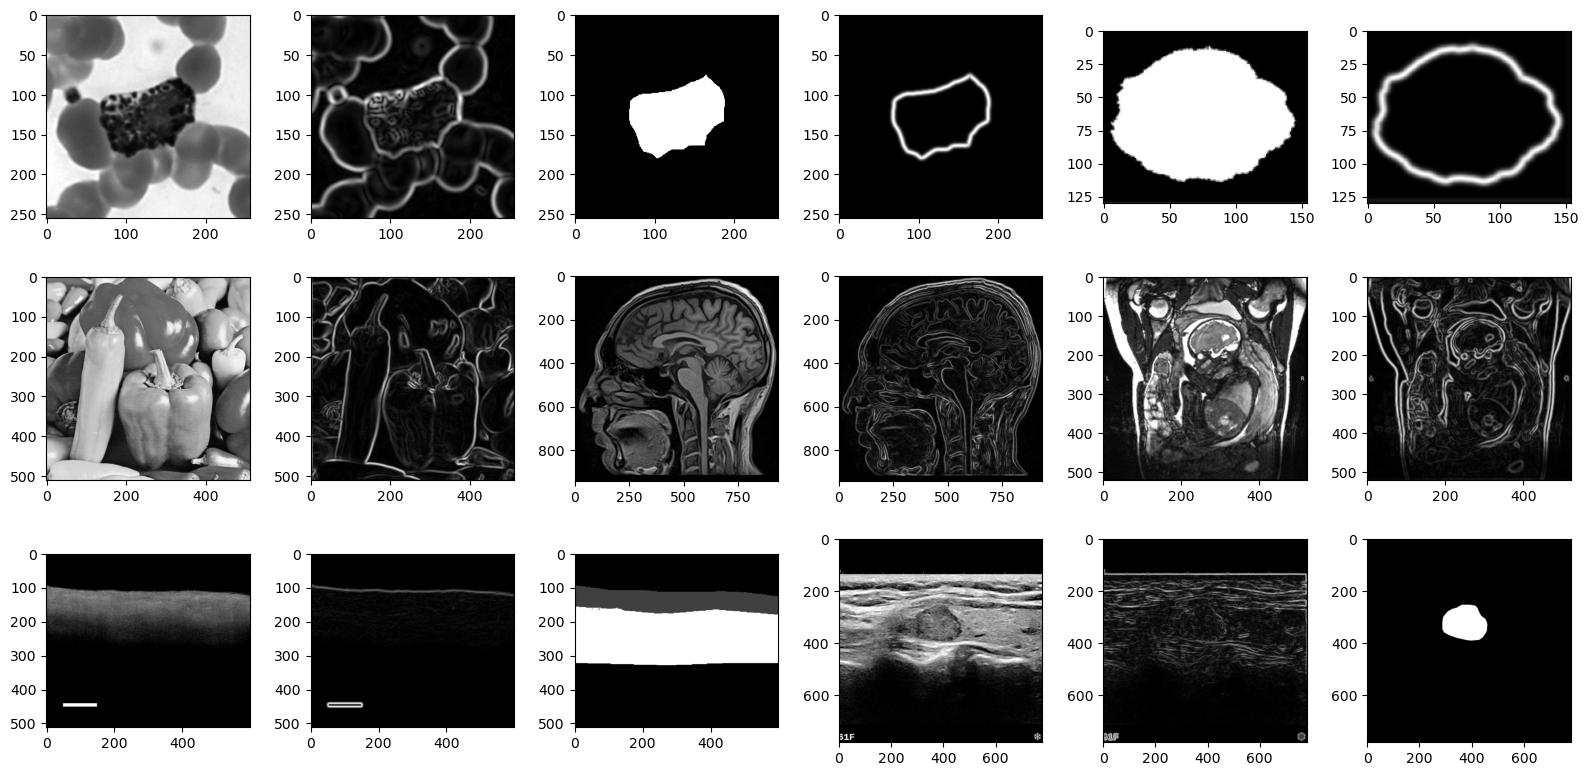

In [3]:
# import warnings
# warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

img_star = skimage.io.imread("./images_misc/smooth_star.png", as_gray=True)
img_star_noisy = skimage.io.imread("./images_misc/smooth_star_noisy.png", as_gray=True)

img_hela = skimage.io.imread("./images_misc/hela_big_gt.png", as_gray=False)
edge_hela = edge_map(img_hela, sigma=2)
img_hela = np.squeeze(img_hela)

img_pepper = skimage.io.imread("./images_misc/peppers_gt.png", as_gray=False)
img_pepper = np.squeeze(img_pepper)
edge_pepper = edge_map(img_pepper, sigma=2)
img_pepper = img_pepper.astype("float64")

img_MRIb = skimage.io.imread("./images_misc/MRI_brain_sag.png", as_gray=True)
edge_MRIb = edge_map(img_MRIb, sigma=2)

img_MRIf = skimage.io.imread("./images_misc/MRI_fetus.png", as_gray=True)
edge_MRIf = edge_map(img_MRIf, sigma=2)

img_cell = skimage.io.imread("./images_blood_cells/000016.png", as_gray=True)
edge_cell = edge_map(img_cell, sigma=2)

img_mask = skimage.io.imread("./masks_blood_cells/000016.png", as_gray=True)
edge_mask = edge_map(img_mask, sigma=2)

img_mask2 = skimage.io.imread("./images_misc/binary_shape_2024.png", as_gray=True)
edge_mask2 = edge_map(img_mask2, sigma=2)

img_OCT = skimage.io.imread("./OCT_myocardium/case272.tif", as_gray=True)
edge_OCT = edge_map(img_OCT, sigma=2)
labels_OCT = skimage.io.imread("./OCT_myocardium/case272_label.tiff", as_gray=True)

img_nodule = skimage.io.imread("./thyroid_nodule/1074.png", as_gray=True)
edge_nodule = edge_map(img_nodule, sigma=2)
labels_nodule = skimage.io.imread("./thyroid_nodule/1074_mask.png", as_gray=True)


fig, axes = plt.subplots(3, 6, figsize=(16, 8))
ax = axes.ravel()

ax[0].imshow(img_cell, cmap=plt.cm.gray)
ax[1].imshow(edge_cell, cmap=plt.cm.gray)
ax[2].imshow(img_mask, cmap=plt.cm.gray)
ax[3].imshow(edge_mask, cmap=plt.cm.gray)
ax[4].imshow(img_mask2, cmap=plt.cm.gray)
ax[5].imshow(edge_mask2, cmap=plt.cm.gray)
ax[6].imshow(img_pepper, cmap=plt.cm.gray)
ax[7].imshow(edge_pepper, cmap=plt.cm.gray)
ax[8].imshow(img_MRIb, cmap=plt.cm.gray)
ax[9].imshow(edge_MRIb, cmap=plt.cm.gray)
ax[10].imshow(img_MRIf, cmap=plt.cm.gray)
ax[11].imshow(edge_MRIf, cmap=plt.cm.gray)
ax[12].imshow(img_OCT, cmap=plt.cm.gray)
ax[13].imshow(edge_OCT, cmap=plt.cm.gray)
ax[14].imshow(labels_OCT, cmap=plt.cm.gray)
ax[15].imshow(img_nodule, cmap=plt.cm.gray)
ax[16].imshow(edge_nodule, cmap=plt.cm.gray)
ax[17].imshow(labels_nodule, cmap=plt.cm.gray)

fig.tight_layout()
plt.show()

# Image properties: 
## Range of values and data type matter ...


Some routines won't work if your image type is int8 or uint8...
Here is how to check your image data type

And regularly check your image content in terms of:
* intensities range of values
* distributions of intensities via its histogram


float64
0.04579333333333333
255.0


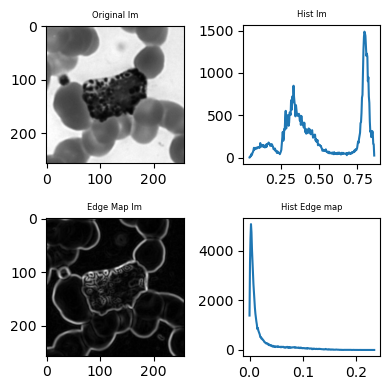

In [4]:
img_test = img_cell
Sigma_val = 1
edge_test = edge_map(img_test, sigma=Sigma_val)

## Print some basic image properties
print(img_test.dtype)
print(np.min(img_test))
print(np.max(img_pepper))

## Show Hist
hist_test, bins_test = np.histogram(img_test.flatten(), bins=256)
hist_edge_test, bins_edges_test = np.histogram(edge_test.flatten(), bins=256)

fig, axes = plt.subplots(2, 2, figsize=(4, 4))
ax = axes.ravel()
ax[0].imshow(img_test, cmap=plt.cm.gray)
ax[0].set_title("Original Im", fontsize=6)
ax[1].plot(bins_test[0:-1], hist_test)
ax[1].set_title("Hist Im", fontsize=6)
ax[2].imshow(edge_test, cmap=plt.cm.gray)
ax[2].set_title("Edge Map Im", fontsize=6)
ax[3].plot(bins_edges_test[0:-1], hist_edge_test)
ax[3].set_title("Hist Edge map", fontsize=6)
fig.tight_layout()
plt.show();

# Edge maps
Deformable models rely on edge maps. Most routines have their own strategy coded to compute the edge map. 

* Edge maps usually involve smoothing of the image, to be robust to noise. Make sure you understand how this is controlled in the routine you use. 
* Edge maps usually show pixels with high gradient magnitudes in white (high values)
* Most deformable model routines can be fed directly with an Edge Map rather than the original image as its input
* Some routine expect to be fed with an inverse edge map where high gradient locations have small values, to stop the contour via a velocity set to ~zero. 

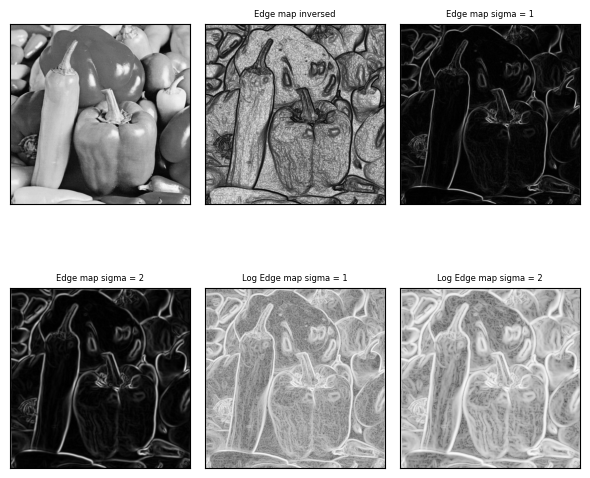

In [5]:
img_to_test = img_pepper

# Classic Edge map with Gaussian smoothing controled by sigma
edge_test1 = edge_map(img_to_test, sigma=1)
edge_test1_l = np.log2(edge_test1)
edge_test2 = edge_map(img_to_test, sigma=2)
edge_test2_l = np.log2(edge_test2)

# Inversed Edge map
# Returns Edge map = 1.0 / np.sqrt(1.0 + alpha * gradnorm)
edge_inv_test = skimage.segmentation.inverse_gaussian_gradient(
    img_to_test, alpha=1.0, sigma=1.0
)

fig, axes = plt.subplots(2, 3, figsize=(6, 6))
ax = axes.ravel()

ax[0].imshow(img_to_test, cmap=plt.cm.gray)
ax[1].imshow(edge_inv_test, cmap=plt.cm.gray)
ax[1].set_title("Edge map inversed", fontsize=6)
ax[2].imshow(edge_test1, cmap=plt.cm.gray)
ax[2].set_title("Edge map sigma = 1", fontsize=6)
ax[3].imshow(edge_test2, cmap=plt.cm.gray)
ax[3].set_title("Edge map sigma = 2", fontsize=6)
ax[4].imshow(edge_test1_l, cmap=plt.cm.gray)
ax[4].set_title("Log Edge map sigma = 1", fontsize=6)
ax[5].imshow(edge_test2_l, cmap=plt.cm.gray)
ax[5].set_title("Log Edge map sigma = 2", fontsize=6)

for i in range(0, 6):
    ax[i].set_xticks([]), ax[i].set_yticks([])

fig.tight_layout()
plt.show()

# Test some image manipulations

Let you test some image transformations based on morphological operators and histogram manipulation. 
When transforming image contrast, it is always interesting to look at the differences between the original image and the transformed version.

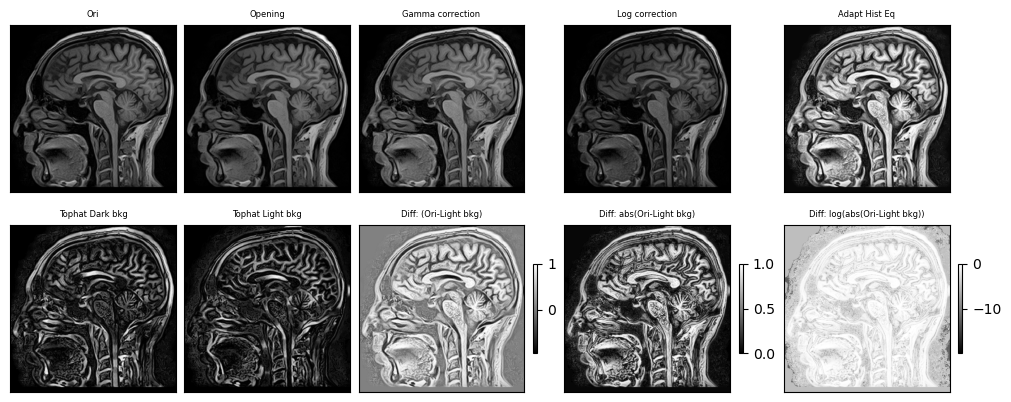

In [6]:
img_ori_to_test = img_MRIb
img_to_test = img_ori_to_test
epsilon = 0.000001  # to prevent log on 0
img_eps = np.full_like(img_to_test, epsilon)
PRE_ENHANCE = 1
OPTION_ENHANCE = (
    4  # can be 0 (nothing) OR 1, 2, 3, 4 for different enchancement options
)

# Run all OPTION_ENHANCE for display here
gamma_corrected = skimage.exposure.adjust_gamma(img_to_test, 0.8)
logarithmic_corrected = skimage.exposure.adjust_log(img_to_test, gain=1, inv=True)
img_open = skimage.morphology.diameter_opening(img_to_test, 40, connectivity=2)
img_adapteq = skimage.exposure.equalize_adapthist(img_to_test, clip_limit=0.03)

# PRE ENHANCEMENT OPTIONS:
if PRE_ENHANCE == 1:
    if OPTION_ENHANCE == 1:
        # Gamma
        img_to_test = gamma_corrected
    elif OPTION_ENHANCE == 2:
        # Logarithmic (O = gain*log(1 + I)) or if Inv (O = gain*(2**I - 1))
        img_to_test = logarithmic_corrected
    elif OPTION_ENHANCE == 3:
        # Morpho Opening
        img_to_test = img_open
    elif OPTION_ENHANCE == 4:
        # Contrast Limited Adaptive Histogram Equalization (CLAHE).
        img_to_test = img_adapteq

# Enhance details either dark around light background of vice versa with the Top-Hat transform
Radius_val = 15
img_test1 = subtract_background(img_to_test, radius=Radius_val, light_bg=False)
img_test2 = subtract_background(img_to_test, radius=Radius_val, light_bg=True)

# SHOW OUTPUTS
fig, axes = plt.subplots(2, 5, figsize=(10, 4), constrained_layout=True)
ax = axes.ravel()
Shrink_factor_colormap = 0.5
ax[0].imshow(img_ori_to_test, cmap=plt.cm.gray)
ax[0].set_title("Ori", fontsize=6)

ax[1].imshow(img_open, cmap=plt.cm.gray)
ax[1].set_title("Opening", fontsize=6)

ax[2].imshow(gamma_corrected, cmap=plt.cm.gray)
ax[2].set_title("Gamma correction", fontsize=6)

ax[3].imshow(logarithmic_corrected, cmap=plt.cm.gray)
ax[3].set_title("Log correction", fontsize=6)

ax[4].imshow(img_adapteq, cmap=plt.cm.gray)
ax[4].set_title("Adapt Hist Eq", fontsize=6)

ax[5].imshow(img_test1, cmap=plt.cm.gray)
ax[5].set_title("Tophat Dark bkg", fontsize=6)

ax[6].imshow(img_test2, cmap=plt.cm.gray)
ax[6].set_title("Tophat Light bkg", fontsize=6)

tmp_show = ax[7].imshow(img_to_test - img_test2, cmap=plt.cm.gray)
ax[7].set_title("Diff: (Ori-Light bkg)", fontsize=6)
plt.colorbar(tmp_show, ax=ax[7], shrink=Shrink_factor_colormap, location="right")

tmp_show = ax[8].imshow(abs(img_to_test - img_test2), cmap=plt.cm.gray)
ax[8].set_title("Diff: abs(Ori-Light bkg)", fontsize=6)
plt.colorbar(tmp_show, ax=ax[8], shrink=Shrink_factor_colormap, location="right")

tmp_show = ax[9].imshow(
    np.log2(abs(img_to_test - img_test2 + img_eps)), cmap=plt.cm.gray
)
ax[9].set_title("Diff: log(abs(Ori-Light bkg))", fontsize=6)
plt.colorbar(tmp_show, ax=ax[9], shrink=Shrink_factor_colormap, location="right")

for i in range(0, 10):
    ax[i].set_xticks([]), ax[i].set_yticks([])

# fig.tight_layout() # not compatible with option constrained_layout=True in
# plt.subplots needed to display the colorbar
plt.show()

# Seg #1: 

## Snake on a binary shape

Based on the routine **active_contour** from skimage. <br>
Default **parameter values** are: <br>
* `alpha=0.01` (Snake length shape parameter. Higher values makes snake contract faster.)
* `beta=0.1` (Snake smoothness shape parameter. Higher values makes snake smoother.)
* `gamma=0.01` (Explicit time stepping parameter - Equivalent to the viscosity of the environment)
* `max_px_move=1.0`
<br>

There are two **other parameters** that define the final image information used to define external forces used to define regions.img = w_line x img + w_edge x edge: <br> 
*   `w_line=0` (default) | `=1` if want to input_edge map directly. Use negative values to attract toward dark 
*   `w_edge=1` (default)  | `=0` if do not want to use internal edge map. Use negative values to repel snake from edges

 
## TODO:

1. Run the cell for `img_to_seg=img_mask` and `img_to_seg=img_mask2` with the sets of parameter values provided. 1st set uses values by default, 2nd-3rd sets use custom values to help improve the smoothness of the final contour. <br>
    1. Comment on defaults seen on the obtained initial segmentations. <br>
    1. Explain why you think increasing the gamma_val has better helped smooth the final contour.  <br>

2. Test now by using a small initial circle inside the white shape. What is happening and what additional force seen in the class could help fixing this issue?

3. Now run the segmentation on the `img_to_seg=img_star` or `img_to_seg=img_star_noisy`. Try the same parameter values adjustments as before to get a smoother final contour. Comment on the issues observed with the two options.

4. BONUS: there is a way to obtain a "perfect" segmentation for the star shape. Propose one solution which might involve many more iterations, once you have checked with few iterations that behavior is stable.


## ANSWERS:

**1.1.** Withe the default set of parameters, we obtain a very irregular contour, which could be a sign that the energy for high contour curvature was not properly accounted for. In spite of that, the contour remains relatively close to the optimal position, near the segmented object.

**1.2.** $\gamma$ is the temporal step in which $f_x$ and $f_y$ are constant, an inertial coefficient equivalent to the viscosity of the environment. Thus, increasing the `gamma_val` helps smooth the final contour as it decreases the size of the step of the snake by making it "harder", more costly, for the snake to move, which, in practice, reduces the snake step size and, consequently, makes it adapts progressively to the shape of the segmented object.

**2.** The contour does not converges to the borders of the segmented object, but instead it closely resembles the initial circle. External forces, to penalize the snake not being on the contours of the object (derived from the gradient) would help to fix this issue. On the code, this would be achieved by changing the parameters `w_line` for negative values and `w_edge` for positive values.

**3.** With the first set of parameters, the contour is very irregular, but is close to the optimal position, specially on `img_star`. With the second set of parameters, the contour is smooth, but respects less the position of the borders of the segmented object. With the third set of parameters, the algorithm provides similar results, albeit a bit smoother, as the first set of parameters. The hardships of the algorithm may be due to the more complex shape (less circular) of the segmented object, which can be corrected by fine-tuning the set of parameters.

**4.** A good set of parameters that makes it possible for the snake to get closer to the segmented object in: `img_star` is `alpha_val = 0.1; beta_val = 0.1e-3; gamma_val = 0.15; convergence_val = 1e-4; Niter_snake = 900`; `image_star_noisy` is `alpha_val = 0.15; beta_val = 1e-4; gamma_val = 0.05; convergence_val = 1e-4; Niter_snake = 900`.

In [7]:
# 1ST images
img_to_seg = img_mask; r0 = 130; c0 = 125; R0 = 60
# img_to_seg = img_mask2; r0 = 75; c0 = 65; R0 = 60

# alpha_val = 0.01; beta_val = 0.1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 800
alpha_val = 0.01; beta_val = 0.1; gamma_val = 0.1; convergence_val = 1e-4; Niter_snake = 800
# alpha_val = 0.01; beta_val = 1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 800

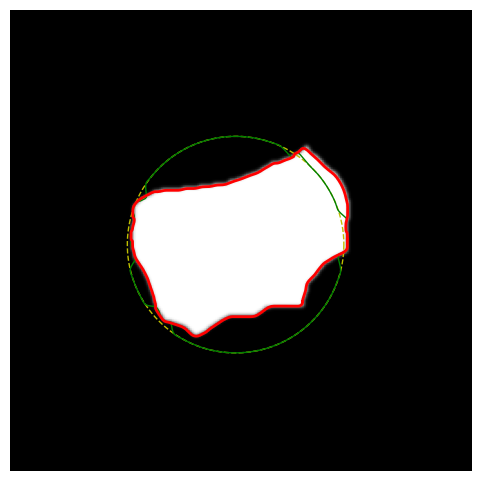

In [8]:
# Initialise contour
init = define_initial_circle(R0, r0, c0)

# Pre-smooth the image
Niter_smooth = 1
img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Run active contour
snake10 = active_contour(
    img_to_seg,
    init,
    max_num_iter=10,
    convergence=convergence_val,
    alpha=alpha_val,
    beta=beta_val,
    gamma=gamma_val
)
snake_max = active_contour(
    img_to_seg,
    init,
    max_num_iter=Niter_snake,
    convergence=convergence_val,
    alpha=alpha_val,
    beta=beta_val,
    gamma=gamma_val
)

# Display results
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], "--y", lw=1)
ax.plot(snake10[:, 1], snake10[:, 0], "-g", lw=1)
ax.plot(snake_max[:, 1], snake_max[:, 0], "-r", lw=2)
plt.axis('off')
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show()

In [9]:
# 2ND image
img_to_seg = img_star; r0 = 64; c0 = 64; R0 = 50
alpha_val = 0.1; beta_val = 0.1e-3; gamma_val = 0.15; convergence_val = 1e-4; Niter_snake = 900

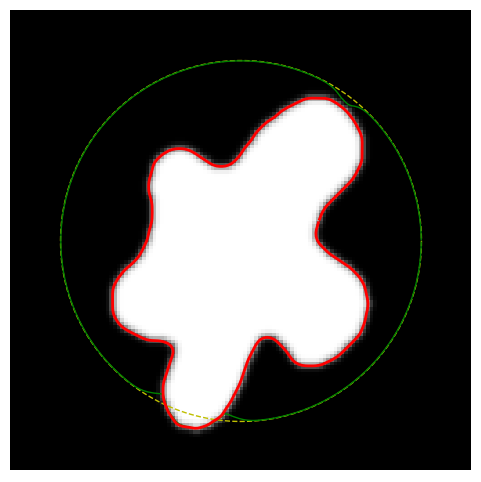

In [10]:
# Initialise contour
init = define_initial_circle(R0, r0, c0)

# Pre-smooth the image
Niter_smooth = 1
img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Run active contour
snake10 = active_contour(
    img_to_seg,
    init,
    max_num_iter=10,
    convergence=convergence_val,
    alpha=alpha_val,
    beta=beta_val,
    gamma=gamma_val
)
snake_max = active_contour(
    img_to_seg,
    init,
    max_num_iter=Niter_snake,
    convergence=convergence_val,
    alpha=alpha_val,
    beta=beta_val,
    gamma=gamma_val
)

# Display results
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], "--y", lw=1)
ax.plot(snake10[:, 1], snake10[:, 0], "-g", lw=1)
ax.plot(snake_max[:, 1], snake_max[:, 0], "-r", lw=2)
plt.axis('off')
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show()

In [11]:
# 3RD image
img_to_seg = img_star_noisy; r0 = 64; c0 = 64; R0 = 50
alpha_val = 0.15; beta_val = 1e-4; gamma_val = 0.05; convergence_val = 1e-4; Niter_snake = 900

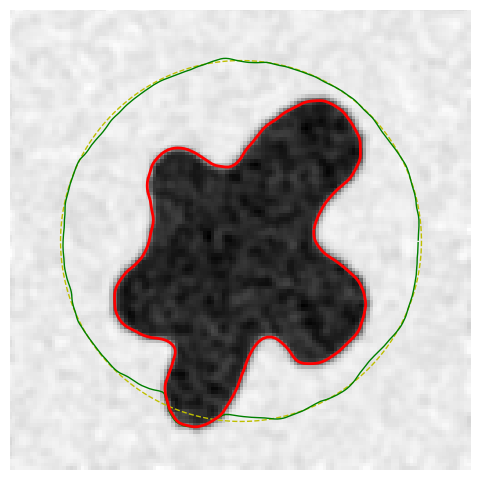

In [12]:
# Initialise contour
init = define_initial_circle(R0, r0, c0)

# Pre-smooth the image
Niter_smooth = 1
img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Run active contour
snake10 = active_contour(
    img_to_seg,
    init,
    max_num_iter=10,
    convergence=convergence_val,
    alpha=alpha_val,
    beta=beta_val,
    gamma=gamma_val
)
snake_max = active_contour(
    img_to_seg,
    init,
    max_num_iter=Niter_snake,
    convergence=convergence_val,
    alpha=alpha_val,
    beta=beta_val,
    gamma=gamma_val
)

# Display results
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], "--y", lw=1)
ax.plot(snake10[:, 1], snake10[:, 0], "-g", lw=1)
ax.plot(snake_max[:, 1], snake_max[:, 0], "-r", lw=2)
plt.axis('off')
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show()

# Seg #2: 

## Snake on a real image 

We are using here **img_to_seg   = img_cell** for which you have a ground truth mask of the target segmentation for the dark cell.  

## TODO

1. **Segment left cell**: 
    1. Run with the proposed initialisation and see that the active contour can be initialised inside the object. Give some intuition on why. 
2. **Segment right cell**:
    1. Run with the proposed initialisation and see that the active contour cannot be initialised inside the object now. Give some intuition on why.
    2. Change the parameter `Niter_smooth` while keeping snake parameters constant and give an intuition on why the final contour evolves as seen. 
    3. Change the initial contour parameters to obtain a perfect segmentation. 
3. BONUS: If you know that you are aiming for the darkest cell in the image, propose an automated initialisation of the initial active contour parameters `[r0 ; c0; R0]` that works on this image.

## ANSWERS

**1.1.** The initialization on the interior of the segmented object allows for a good detection of the contour, as the initialization on the exterior would risk to incorrectly attract the snake to the borders of others different cells.

**2.1.** The cell on the middle is heterogeneous and has a complex texture which makes the initialization on the inside of the segmented object inviable as it would be complex to define a set of parameters that would properly attract the snake to the borders.

**2.2.** The increase of the parameter `Niter_smooth` helps the detection of the proper border of the segmented object, as the cell becomes more homogeneous and its texture becomes simpler. However, the image looses a considerable quantity of information, and the borders of the object become too blurred for an acceptable segmentation.

**2.3.** With the set of contour parameters `r0 = 130; c0 = 120; R0 = 65`, it is possible to perfectly segment the image. 

<!-- **3.** -->

In [13]:
# 1st SEG: To segment left cell
img_to_seg = img_cell
r0 = 150; c0 = 50; R0 = 30
alpha_val = 0.01; beta_val = 0.1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200

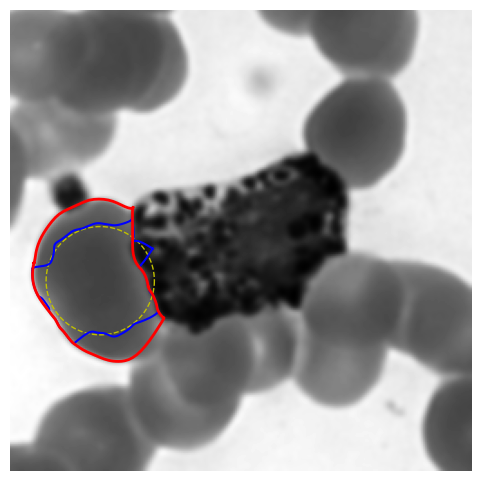

In [14]:
# Pre smooth the image
Niter_smooth = 1
img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
init = define_initial_circle(R0, r0, c0)

# Run active contour
snake30 = active_contour(
    img_to_seg,
    init,
    max_num_iter=30,
    convergence=convergence_val,
    alpha=alpha_val,
    beta=beta_val,
    gamma=gamma_val,
)

snake = active_contour(
    img_to_seg,
    init,
    max_num_iter=Niter_snake,
    convergence=convergence_val,
    alpha=alpha_val,
    beta=beta_val,
    gamma=gamma_val,
)

# Display results
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], "--y", lw=1)
ax.plot(snake30[:, 1], snake30[:, 0], "-b", lw=1.5)
ax.plot(snake[:, 1], snake[:, 0], "-r", lw=2)
plt.axis('off')
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show()

In [15]:
# 2nd SEG: To segment center dark cell
img_to_seg = img_cell
r0 = 130; c0 = 120; R0 = 65
alpha_val = 0.01; beta_val = 0.1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 800


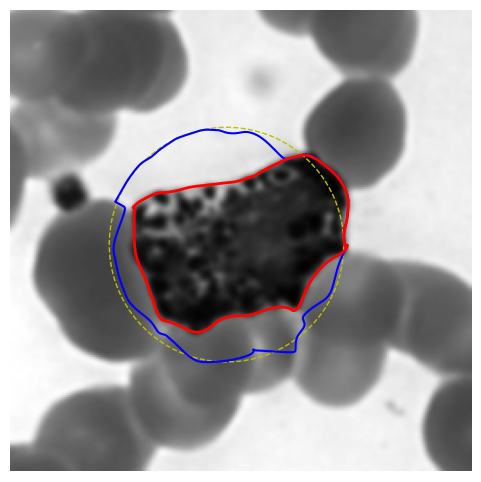

In [16]:
# Pre smooth the image
Niter_smooth = 1
img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
init = define_initial_circle(R0, r0, c0)

# Run active contour
snake30 = active_contour(
    img_to_seg,
    init,
    max_num_iter=30,
    convergence=convergence_val,
    alpha=alpha_val,
    beta=beta_val,
    gamma=gamma_val,
)

snake = active_contour(
    img_to_seg,
    init,
    max_num_iter=Niter_snake,
    convergence=convergence_val,
    alpha=alpha_val,
    beta=beta_val,
    gamma=gamma_val,
)

# Display results
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], "--y", lw=1)
ax.plot(snake30[:, 1], snake30[:, 0], "-b", lw=1.5)
ax.plot(snake[:, 1], snake[:, 0], "-r", lw=2)
plt.axis('off')
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show()

# Seg # 3

## A tool to visualise the deformations of the snake

## TO DO:

1. **Segment left cell**:
    1. Provide your comments on the deformation pattern of the snake. 
    2. Why iteration time steps get slower over iterations when initialising from the inside? 
2. **Segment right cell**:
     1. Use your optimal parameters from previous cell and comment on the deformation patterns.

## ANSWERS

**1.1.** In a first moment, the algorithm is still searching for the position of the border of the segmented object, which is apparent by the rapidly growing and irregularly shaped contour. Once the algorithm has roughly identified the position of the border, it begins then to smooth the snake as to adapt its curvature to the proper border of the cell.

**1.2.** The iteration time steps get slower over iterations when initializing from the inside as, once the snake has already grown to the rough position of the borders of the cell, it must then progressively search for the precise location of the border, accounting for the curvature of the snake (and its overall length). Thus, as not to step further away from the found minima, it slowly steps towards its direction. The fact that the image is relatively blurred, with no sharp definition of the borders, also contributes to the decrease on the steps.

**2.1.** The algorithm needs more iterations to properly segment the right cell, as the initialization on the outside interacts with the border of different cells. This makes it more complex for the snake to be attracted to the proper border of the right cell and to distinguish the clearer background from the rest of the cells. With sufficient iterations, in a first moment, the snake is attracted to the borders of the wrong cells, and then it proceeds to search for the right cell.

In [17]:
# 1st SEG: To segment left cell
img_to_seg = img_cell; r0 = 150; c0 = 50; R0 = 30
alpha_val = 0.01; beta_val = 0.1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200

start  1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


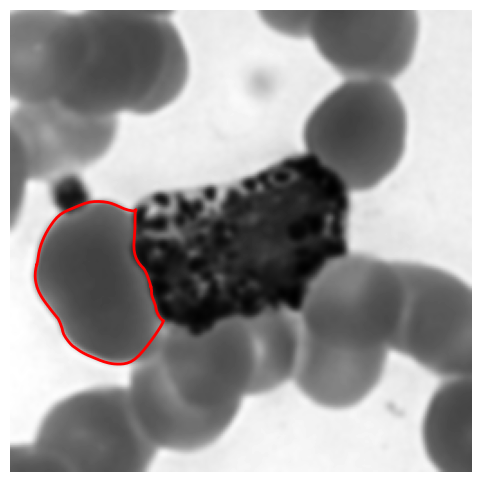

In [18]:
# Pre smooth the image
Niter_smooth = 1
img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
init = define_initial_circle(R0, r0, c0)

# Run active contour while saving intermediate contours to see deformations
segs = []
print("start", " ", end="")
for i in range(1, Niter_snake, 10):
    print(i, " ", end="")
    segs.append(
        active_contour(
            img_to_seg,
            init,
            max_num_iter=i,
            convergence=convergence_val,
            alpha=alpha_val,
            beta=beta_val,
            gamma=gamma_val,
        )
    )

print("stop")
np.save("ANIM_contours.npy", np.array(segs))

# display animation
segs = np.load("ANIM_contours.npy")
anim = animate_snake(img_to_seg, segs)
HTML(anim.to_html5_video())

In [19]:
# 2nd SEG: To segment center dark cell
img_to_seg = img_cell; r0 = 130; c0=120; R0 = 65
alpha_val = 0.01; beta_val = 0.1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 800

start  1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291  301  311  321  331  341  351  361  371  381  391  401  411  421  431  441  451  461  471  481  491  501  511  521  531  541  551  561  571  581  591  601  611  621  631  641  651  661  671  681  691  701  711  721  731  741  751  761  771  781  791  stop


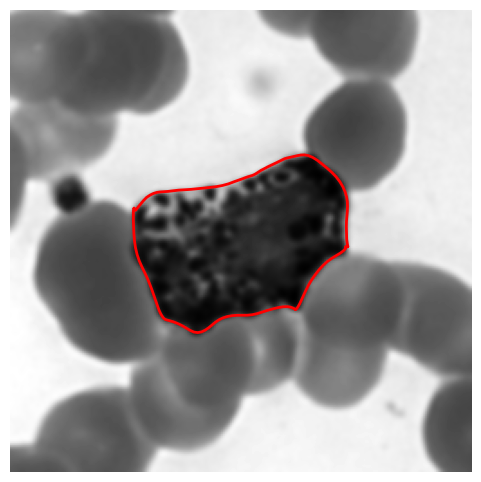

In [20]:
# Pre smooth the image
Niter_smooth = 1
img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
init = define_initial_circle(R0, r0, c0)

# Run active contour while saving intermediate contours to see deformations
segs = []
print("start", " ", end="")
for i in range(1, Niter_snake, 10):
    print(i, " ", end="")
    segs.append(
        active_contour(
            img_to_seg,
            init,
            max_num_iter=i,
            convergence=convergence_val,
            alpha=alpha_val,
            beta=beta_val,
            gamma=gamma_val,
        )
    )

print("stop")
np.save("ANIM_contours.npy", np.array(segs))

# display animation
segs = np.load("ANIM_contours.npy")
anim = animate_snake(img_to_seg, segs)
HTML(anim.to_html5_video())

# Seg # 4

## Snake with  Gradient Vector Flow (GVF)
This implementation of the GVF is performed by computing the edge map, diffusing the gradient over the whole image and directly input the GVF_edge_map to be used as external forces by setting w_line=1 and w_edge=0 in the active_contour function.

## TODO: 

1. Compare results when segmenting the Edge_map or GVF_map as input to the active_contour routine on 3 images: `img_star`, `img_star_noisy` and an image of your choice. Comment on robustness and speed differences. 
2. When using GVF_map, test the effect of decreasing by a factor of 10 alpha, beta or gamma and interpret the effect.

## ANSWERS

**1.** **Edge_map**: for `img_star` and `img_star_noisy`, the contour is close to the real contour, albeit their smoothness could still be improved a little; the latter converges faster than the former. For `img_cell` (left or right cell), the position of the contour is not as exact, however it remains inside the cell and is considerably smooth. **GVF_map**: Generally, smoother contours are observed and the algorithm converges much faster than for Edge_map, but for `img_star`, very irregular artifacts are observed. It requires a significantly longer time to segment the cell, but the result is very smooth. For `img_cell` (left or right cell), the result is even less satisfactory than with Edge_map.

**2.** Lowering the alpha value slows down the contraction speed of the snake, as alpha signifies the snake's length shape. Consequently, the snake requires more iterations to converge towards the optimal contour. A reduction in the beta value diminishes the smoothness of the snake, given that beta serves as a penalization factor for high curvature in the snake. Similarly, a decrease in gamma also reduces the smoothness of the snake by enlarging the step size, effectively decreasing the "viscosity" of the environment. This alteration makes forces have a greater impact on the snake's momentum, influencing its path more readily.

In [21]:
import gvf_elsa2
from gvf_elsa2 import gradient_field, gradient_vector_flow

In [22]:
img_to_seg = img_star; r0 = 64; c0 = 64; R0 = 50
alpha_val = 0.1; beta_val = 0.1e-3; gamma_val = 0.15; convergence_val = 1e-4; Niter_snake = 900

In [23]:
# Initialise contour
init = define_initial_circle(R0, r0, c0, Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map = edge_map(img_to_seg, sigma=1)

fx, fy = gradient_field(img_to_seg)
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

................................................................................................................................


start  1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291  301  311  321  331  341  351  361  371  381  391  401  411  421  431  441  451  461  471  481  491  501  511  521  531  541  551  561  571  581  591  601  611  621  631  641  651  661  671  681  691  701  711  721  731  741  751  761  771  781  791  801  811  821  831  841  851  861  871  881  891  stop


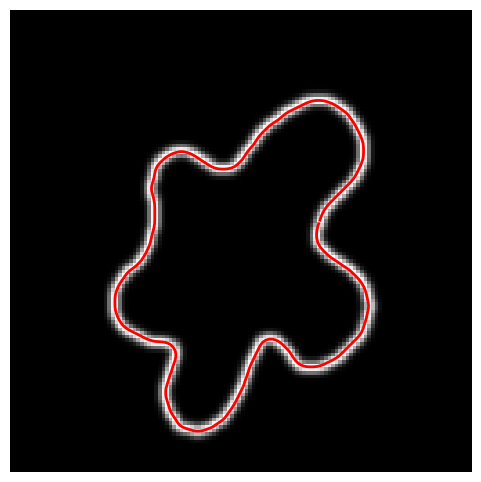

In [24]:
# Run active contour while saving intermediate contours to see deformations
Map_to_seg = Edge_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print("start", " ", end="")
for i in range(1, Niter_snake, 10):
    print(i, " ", end="")
    segs.append(
        active_contour(
            Map_to_seg,
            init,
            max_num_iter=i,
            convergence=convergence_val,
            alpha=alpha_val,
            beta=beta_val,
            gamma=gamma_val,
            w_line=1,
            w_edge=0,
        )
    )

print("stop")
np.save("ANIM_contours.npy", np.array(segs))

# display animation
segs = np.load("ANIM_contours.npy")
anim = animate_snake(Map_to_seg, segs)
HTML(anim.to_html5_video())

start  1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291  301  311  321  331  341  351  361  371  381  391  401  411  421  431  441  451  461  471  481  491  501  511  521  531  541  551  561  571  581  591  601  611  621  631  641  651  661  671  681  691  701  711  721  731  741  751  761  771  781  791  801  811  821  831  841  851  861  871  881  891  stop


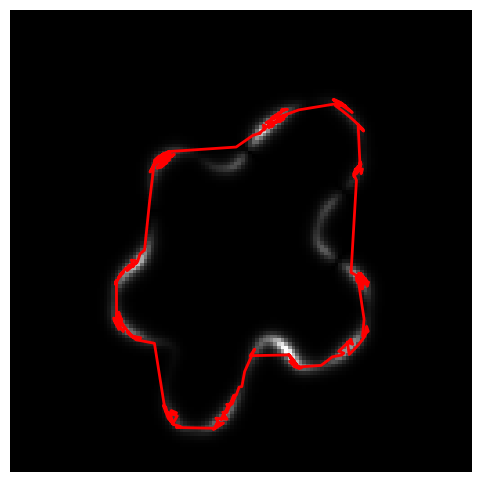

In [25]:
# Run active contour while saving intermediate contours to see deformations
Map_to_seg = GVF_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print("start", " ", end="")
for i in range(1, Niter_snake, 10):
    print(i, " ", end="")
    segs.append(
        active_contour(
            Map_to_seg,
            init,
            max_num_iter=i,
            convergence=convergence_val,
            alpha=alpha_val,
            beta=beta_val,
            gamma=gamma_val,
            w_line=1,
            w_edge=0,
        )
    )

print("stop")
np.save("ANIM_contours.npy", np.array(segs))

# display animation
segs = np.load("ANIM_contours.npy")
anim = animate_snake(Map_to_seg, segs)
HTML(anim.to_html5_video())

In [26]:
img_to_seg = img_star_noisy; r0 = 64; c0 = 64; R0 = 50
alpha_val = 0.15; beta_val = 1e-4; gamma_val = 0.05; convergence_val = 1e-4; Niter_snake = 900

In [27]:
# Initialise contour
init = define_initial_circle(R0, r0, c0, Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map = edge_map(img_to_seg, sigma=1)

fx, fy = gradient_field(img_to_seg)
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

................................................................................................................................


start  1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291  301  311  321  331  341  351  361  371  381  391  401  411  421  431  441  451  461  471  481  491  501  511  521  531  541  551  561  571  581  591  601  611  621  631  641  651  661  671  681  691  701  711  721  731  741  751  761  771  781  791  801  811  821  831  841  851  861  871  881  891  stop


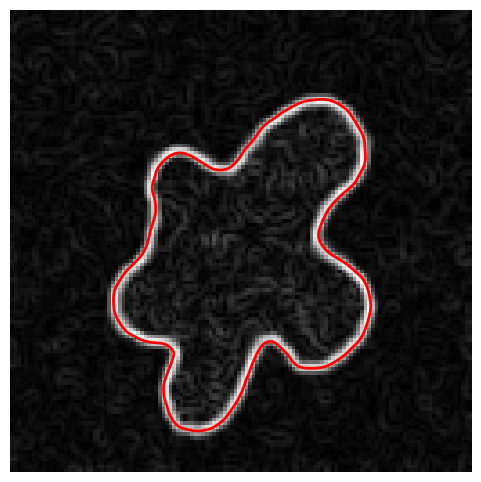

In [28]:
# Run active contour while saving intermediate contours to see deformations
Map_to_seg = Edge_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print("start", " ", end="")
for i in range(1, Niter_snake, 10):
    print(i, " ", end="")
    segs.append(
        active_contour(
            Map_to_seg,
            init,
            max_num_iter=i,
            convergence=convergence_val,
            alpha=alpha_val,
            beta=beta_val,
            gamma=gamma_val,
            w_line=1,
            w_edge=0,
        )
    )

print("stop")
np.save("ANIM_contours.npy", np.array(segs))

# display animation
segs = np.load("ANIM_contours.npy")
anim = animate_snake(Map_to_seg, segs)
HTML(anim.to_html5_video())

start  1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291  301  311  321  331  341  351  361  371  381  391  401  411  421  431  441  451  461  471  481  491  501  511  521  531  541  551  561  571  581  591  601  611  621  631  641  651  661  671  681  691  701  711  721  731  741  751  761  771  781  791  801  811  821  831  841  851  861  871  881  891  stop


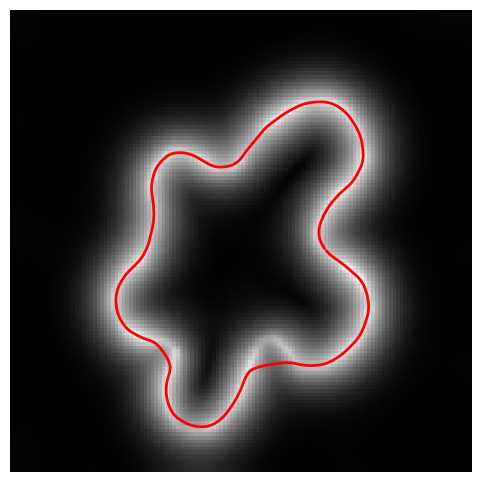

In [29]:
# Run active contour while saving intermediate contours to see deformations
Map_to_seg = GVF_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print("start", " ", end="")
for i in range(1, Niter_snake, 10):
    print(i, " ", end="")
    segs.append(
        active_contour(
            Map_to_seg,
            init,
            max_num_iter=i,
            convergence=convergence_val,
            alpha=alpha_val,
            beta=beta_val,
            gamma=gamma_val,
            w_line=1,
            w_edge=0,
        )
    )

print("stop")
np.save("ANIM_contours.npy", np.array(segs))

# display animation
segs = np.load("ANIM_contours.npy")
anim = animate_snake(Map_to_seg, segs)
HTML(anim.to_html5_video())

In [30]:
img_to_seg = img_cell

# 1st SEG: To segment left cell
r0 = 150; c0 = 50; R0 = 30
alpha_val = 0.01; beta_val = 0.1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 200


In [31]:
# Initialise contour
init = define_initial_circle(R0, r0, c0, Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map = edge_map(img_to_seg, sigma=1)

fx, fy = gradient_field(img_to_seg)
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

................................................................................................................................................................................................................................................................


start  1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


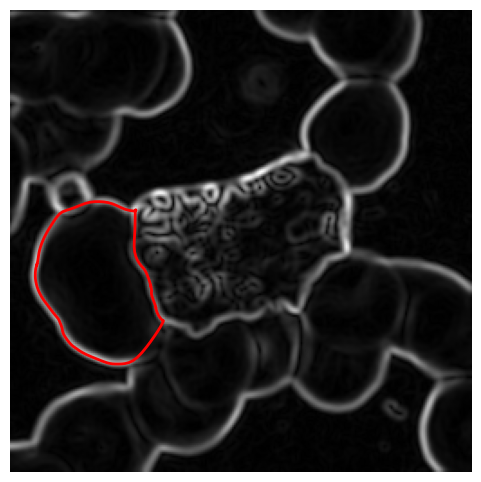

In [32]:
# Run active contour while saving intermediate contours to see deformations
Map_to_seg = Edge_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print("start", " ", end="")
for i in range(1, Niter_snake, 10):
    print(i, " ", end="")
    segs.append(
        active_contour(
            Map_to_seg,
            init,
            max_num_iter=i,
            convergence=convergence_val,
            alpha=alpha_val,
            beta=beta_val,
            gamma=gamma_val,
            w_line=1,
            w_edge=0,
        )
    )

print("stop")
np.save("ANIM_contours.npy", np.array(segs))

# display animation
segs = np.load("ANIM_contours.npy")
anim = animate_snake(Map_to_seg, segs)
HTML(anim.to_html5_video())

start  1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


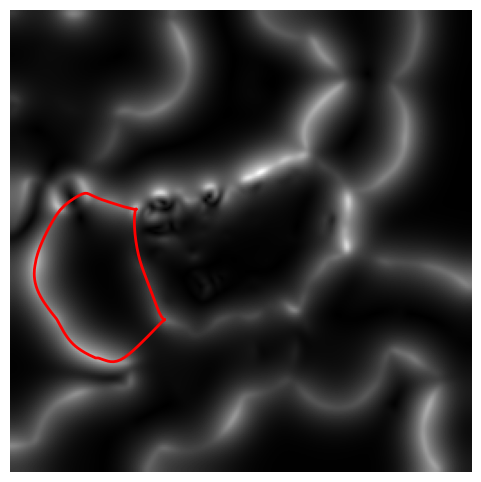

In [33]:
# Run active contour while saving intermediate contours to see deformations
Map_to_seg = GVF_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print("start", " ", end="")
for i in range(1, Niter_snake, 10):
    print(i, " ", end="")
    segs.append(
        active_contour(
            Map_to_seg,
            init,
            max_num_iter=i,
            convergence=convergence_val,
            alpha=alpha_val,
            beta=beta_val,
            gamma=gamma_val,
            w_line=1,
            w_edge=0,
        )
    )

print("stop")
np.save("ANIM_contours.npy", np.array(segs))

# display animation
segs = np.load("ANIM_contours.npy")
anim = animate_snake(Map_to_seg, segs)
HTML(anim.to_html5_video())

In [34]:
# 2nd SEG: To segment center dark cell
img_to_seg = img_cell; r0 = 130; c0=120; R0 = 65
alpha_val = 0.01; beta_val = 0.1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 800

In [35]:
# Initialise contour
init = define_initial_circle(R0, r0, c0, Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map = edge_map(img_to_seg, sigma=1)

fx, fy = gradient_field(img_to_seg)
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

................................................................................................................................................................................................................................................................


start  1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291  301  311  321  331  341  351  361  371  381  391  401  411  421  431  441  451  461  471  481  491  501  511  521  531  541  551  561  571  581  591  601  611  621  631  641  651  661  671  681  691  701  711  721  731  741  751  761  771  781  791  stop


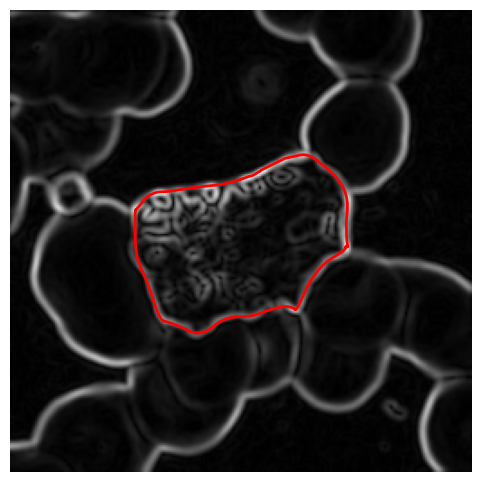

In [36]:
# Run active contour while saving intermediate contours to see deformations
Map_to_seg = Edge_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print("start", " ", end="")
for i in range(1, Niter_snake, 10):
    print(i, " ", end="")
    segs.append(
        active_contour(
            Map_to_seg,
            init,
            max_num_iter=i,
            convergence=convergence_val,
            alpha=alpha_val,
            beta=beta_val,
            gamma=gamma_val,
            w_line=1,
            w_edge=0,
        )
    )

print("stop")
np.save("ANIM_contours.npy", np.array(segs))

# display animation
segs = np.load("ANIM_contours.npy")
anim = animate_snake(Map_to_seg, segs)
HTML(anim.to_html5_video())

start  1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291  301  311  321  331  341  351  361  371  381  391  401  411  421  431  441  451  461  471  481  491  501  511  521  531  541  551  561  571  581  591  601  611  621  631  641  651  661  671  681  691  701  711  721  731  741  751  761  771  781  791  stop


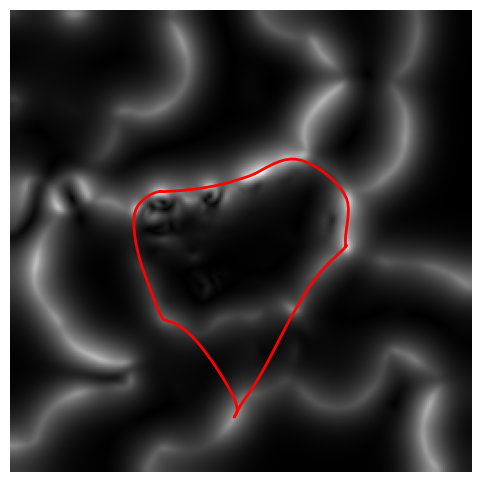

In [37]:
# Run active contour while saving intermediate contours to see deformations
Map_to_seg = GVF_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print("start", " ", end="")
for i in range(1, Niter_snake, 10):
    print(i, " ", end="")
    segs.append(
        active_contour(
            Map_to_seg,
            init,
            max_num_iter=i,
            convergence=convergence_val,
            alpha=alpha_val,
            beta=beta_val,
            gamma=gamma_val,
            w_line=1,
            w_edge=0,
        )
    )

print("stop")
np.save("ANIM_contours.npy", np.array(segs))

# display animation
segs = np.load("ANIM_contours.npy")
anim = animate_snake(Map_to_seg, segs)
HTML(anim.to_html5_video())

# Seg # 5:

### The active contour with fixed end points
You will now run the active_contour with the option to maintain some points from the inital contour fixed. You are working now with the img_nodule which is an ultrasound showing different layers of tissue under the skin surface.

## TO DO:
* Write a loop to vary the initial line vertical position by few pixels and propose a method to aggregate final contours, like for example a probability edge map. 
* BONUS: Propose and implement a metric to measure the "quality" of the segmented contour, as being representative of the "interface" between two tissues. 


In [38]:
img_to_seg = img_nodule
r_left = 170; r_right = 170; c_left = 0; c_right = 780
# r_left = 200; r_right = 190; c_left = 0; c_right = 780
# r_left = 230; r_right = 210; c_left = 0; c_right = 780

alpha_val = 0.01; beta_val = 0.1; gamma_val = 0.01; convergence_val = 1e-4; Niter_snake = 500; w_line_val = 0; w_edge_val = 1

In [39]:
# Pre smooth the image
img_to_seg = skimage.exposure.equalize_adapthist(img_to_seg, clip_limit=0.03)
Niter_smooth = 1
img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
Nber_pts_contour = 300
r = np.linspace(r_left, r_right, Nber_pts_contour)
c = np.linspace(c_left, c_right, Nber_pts_contour)
init = np.array([r, c]).T

probability_edge_map = np.zeros(np.array(img_to_seg.shape) + 1)

for i in range(29):
    snake = active_contour(
        img_to_seg,
        init,
        boundary_condition="fixed-fixed",
        max_num_iter=Niter_snake,
        alpha=alpha_val,
        beta=beta_val,
        gamma=gamma_val,
        w_line=w_line_val,
        w_edge=w_edge_val,
    ).astype(int)

    for j, k in snake:
        probability_edge_map[int(j), int(k)] += 1

    init[:, 0] += 1

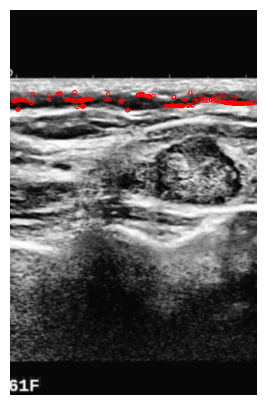

In [40]:
threshold = 4
contour = probability_edge_map > threshold

fig, ax = plt.subplots(figsize=(9, 5))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
plt.contour(contour, colors="red", linewidths=3)
plt.axis('off')
ax.set(xlim=(0, 500))
plt.show()

# Seg # 6

### Your turn on proposing a motivated pipeline using the snake capabilities from the active_contour function

## TODO: 
Choose a new image in the pool provided and propose a segmentation pipeline using the active_contour approach. Options on points to work on include: <br>
* Pre filter the image as you wish
* Manually or automatically position the initial contour
* Provide one segmentation result or merge several solutions in a probability map
* Detect issues in contour shape during deformations and propose an early stop criteria. 

In [41]:
img_to_seg = skimage.io.imread("./images_blood_cells/000031.png", as_gray = True)
r0 = 125; c0 = 130; R0 = 50
alpha_val = 0.1; beta_val = 0.1; gamma_val = 0.02; convergence_val = 1e-4; Niter_snake =1000

In [42]:
init = define_initial_circle(R0, r0, c0)

# Niter_smooth = 1
# img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

probability_edge_map = np.zeros(np.array(img_to_seg.shape) + 1)

for i in range(10):
    init = define_initial_circle(R0 + i, r0, c0)
    snake = active_contour(
        img_to_seg,
        init,
        max_num_iter=Niter_snake,
        convergence=convergence_val,
        alpha=alpha_val,
        beta=beta_val,
        gamma=gamma_val,
    )

    for j, k in snake:
        probability_edge_map[int(j), int(k)] += 1

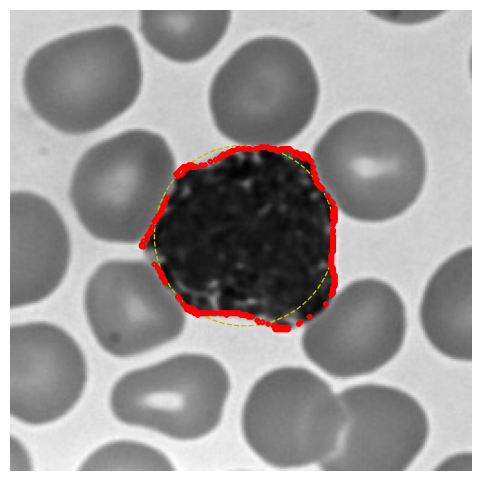

In [43]:
threshold = 5
contour = probability_edge_map > threshold

init = define_initial_circle(R0, r0, c0)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_to_seg, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], "--y", lw=1)
plt.contour(contour, colors="red", linewidths=3)
plt.axis('off')
ax.axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show()

# Seg #7

### Test on the Geometric Level-Set formulation using the Chan-Vese model. 
Skimage provides two implementations of the Chan-Vese approach: `morphological_chan_vese` and `chan_vese`. <br>

The contours of ojects are now encoded in a level set function **Phi**.

The **initialisation** tested here is with a "checkerboard" pattern for 2 classes (object and background). <br>

For the `chan_vese` original implementation, the **hyper-parameters** include:<br>
* `mu=0.25` (default) | edge regularisation terms. Similar to ‘edge length’ weight parameter. Higher mu values will produce ‘smoother’ contours.
* `dt=0.5` (default) |  delta time step for each optimisation step.  
* `lambda1=1`, `lambda2=1` (default) | weights in the cost metric to balance inside and outside homogeneity terms. 
* `tol=1e-3` (default) | Tolerance to test if the contours are "stable" and stop early.

The output contains: `cv[0]=Seg` and `cv[1]=Phi` <br>

For the `morphological_chan_vese`  implementation, the only **hyper-parameter** is the number of smoothing iterations (1 to 4 recommended).<br>

## TO DO:
1. C-V ori: Run the code on `img_hela`. Visualise and explain  evolution of Phi over first iterations. Figure out how to see the initial Phi configuration. 
2. Run now on `img_cell` without and with pre-processing with histogram equalization and explain difference in results.
3. Propose and implement method(s) and metrics to compare two segmentation results when handling segmentation masks. Use the one(s) implemented to quantify the differences obtained on one test case of your choice with the two implementations of chan-vese provided here. 
4. Make the level set work when initializing with `"disk"` on img_MRIf 


## ANSWERS

**1.** The evolution of Phi in the Chan-Vese segmentation algorithm involves iteratively updating the level set function using a partial differential equation that minimizes an energy functional comprising data fitting, smoothness, and regularization terms. The parameter Phi represents the evolving contour in the image segmentation process. Therefore, the algorithm will attempt to move the contour as to segment regions of the image where the variances are different between the inside and the outside.

A possible way to visualize the initial Phi configuration would be to set the number of iterations to 1 (through `Num_iter_cv_ori=1` or `Num_iter_cv_fast=1`), and use the following code: 

```
plt.figure(figsize=(7, 7))
plt.imshow(cv[1], cmap=plt.cm.gray)
plt.show()
```

**2.** The algorithm's output, when not utilizing histogram equalization, faces difficulty in distinguishing the black cell from the surrounding image, as all cells are treated as a single large object. In contrast, employing equalization produces superior results by effectively segregating the individual cells from the background.

**3.** The Mean Squared Error (MSE) serves as a pixel-wise metric, determining the average of squared differences in pixel intensities between two images. Widely utilized, it provides a quantitative measure of the dissimilarity between images. Examining the results of the two different implementations of chan-vese reveals a remarkably low MSE, indicative of minimal disparity between the images. In essence, the small MSE value suggests a high degree of similarity between the compared images.

**4.** For the level set to work when initialized with `"disk"`, it was necessary to change the `mu_val` parameter to `1e-2`, as the contour of the segmented object is very irregular.

In [44]:
img_to_seg = img_hela

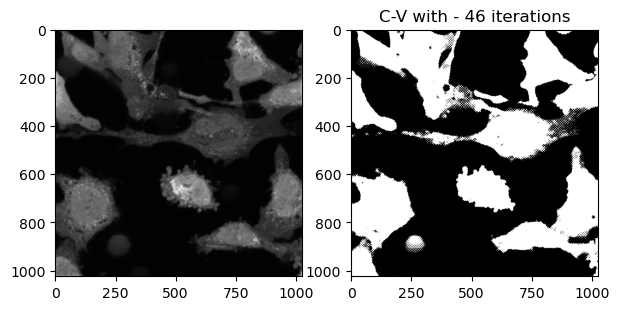

In [45]:
# PARAMETERS
mu_val = 0.5; lambda1_val = 1; lambda2_val = 1; tol_val = 1e-3; dt_val = 0.5
smoothing_val = 3

Num_iter_cv_ori = 100
Num_iter_cv_fast = 1

CHAN_VESE_ORI = 1
Init_method = "checkerboard"  # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)

# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper
    init_ls = checkerboard_level_set(img_to_seg.shape, 45)
    cv = chan_vese(
        img_to_seg,
        mu=mu_val,
        lambda1=lambda1_val,
        lambda2=lambda2_val,
        tol=tol_val,
        dt=dt_val,
        max_num_iter=Num_iter_cv_ori,
        init_level_set=Init_method,
        extended_output=True,
    )
    fig, ax = plt.subplots(1, 2, figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1 - cv[0], cmap=plt.cm.gray)
    title = f"C-V with - {len(cv[2])} iterations"
    ax[1].set_title(title, fontsize=12)
else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv = morphological_chan_vese(
        img_to_seg,
        num_iter=Num_iter_cv_fast,
        smoothing=smoothing_val,
        init_level_set="checkerboard",
    )
    fig, ax = plt.subplots(1, 2, figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1 - cv, cmap=plt.cm.gray)
    title = f"C-V_morph with - {Num_iter_cv_fast} iterations"
    ax[1].set_title(title, fontsize=12)

plt.show()

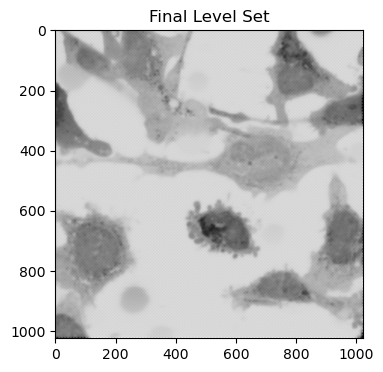

In [46]:
plt.figure(figsize=(4, 4))
plt.imshow(cv[1], cmap=plt.cm.gray)
plt.title("Final Level Set")
plt.show()

In [47]:
from skimage.metrics import mean_squared_error

cv1 = chan_vese(
    img_to_seg,
    mu=mu_val,
    lambda1=lambda1_val,
    lambda2=lambda2_val,
    tol=tol_val,
    dt=dt_val,
    max_num_iter=Num_iter_cv_ori,
    init_level_set=Init_method,
    extended_output=True,
)
cv2 = morphological_chan_vese(
    img_to_seg,
    num_iter=Num_iter_cv_fast,
    smoothing=smoothing_val,
    init_level_set="checkerboard",
)

print("MSE between the two methods: ", mean_squared_error(cv1[0], cv2))

MSE between the two methods:  0.033514976501464844


In [48]:
img_to_seg = img_cell

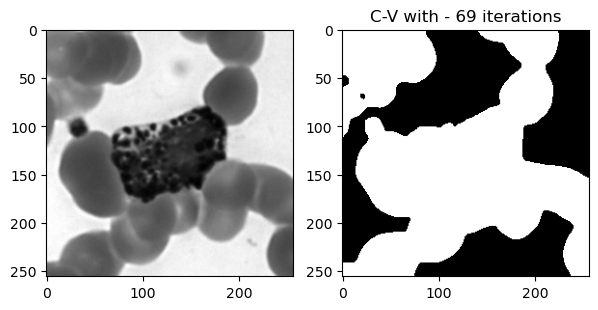

In [49]:
# PARAMETERS
mu_val = 0.5; lambda1_val = 1; lambda2_val = 1; tol_val = 1e-3; dt_val = 0.5
smoothing_val = 3

Num_iter_cv_ori = 100
Num_iter_cv_fast = 1

CHAN_VESE_ORI = 1
Init_method = "checkerboard"  # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)

# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper
    init_ls = checkerboard_level_set(img_to_seg.shape, 45)
    cv = chan_vese(
        img_to_seg,
        mu=mu_val,
        lambda1=lambda1_val,
        lambda2=lambda2_val,
        tol=tol_val,
        dt=dt_val,
        max_num_iter=Num_iter_cv_ori,
        init_level_set=Init_method,
        extended_output=True,
    )
    fig, ax = plt.subplots(1, 2, figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(cv[0], cmap=plt.cm.gray)
    title = f"C-V with - {len(cv[2])} iterations"
    ax[1].set_title(title, fontsize=12)
else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv = morphological_chan_vese(
        img_to_seg,
        num_iter=Num_iter_cv_fast,
        smoothing=smoothing_val,
        init_level_set="checkerboard",
    )
    fig, ax = plt.subplots(1, 2, figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(cv, cmap=plt.cm.gray)
    title = f"C-V_morph with - {Num_iter_cv_fast} iterations"
    ax[1].set_title(title, fontsize=12)

plt.show()

In [50]:
# Histogram equalization
# img_to_seg = skimage.exposure.equalize_hist(img_cell)
img_to_seg = skimage.exposure.equalize_adapthist(img_to_seg, clip_limit=0.03)

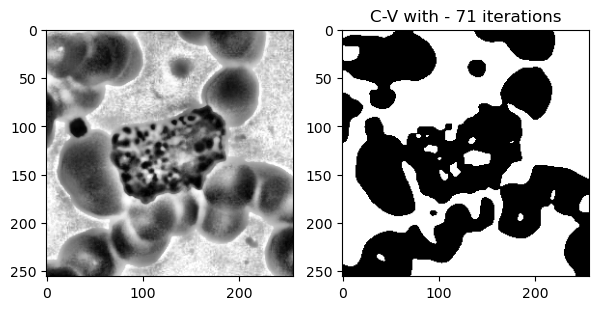

In [51]:
# PARAMETERS
mu_val = 0.5; lambda1_val = 1; lambda2_val = 1; tol_val = 1e-3; dt_val = 0.5
smoothing_val = 3

Num_iter_cv_ori = 100
Num_iter_cv_fast = 1

CHAN_VESE_ORI = 1
Init_method = "checkerboard"  # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)

# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper
    init_ls = checkerboard_level_set(img_to_seg.shape, 45)
    cv = chan_vese(
        img_to_seg,
        mu=mu_val,
        lambda1=lambda1_val,
        lambda2=lambda2_val,
        tol=tol_val,
        dt=dt_val,
        max_num_iter=Num_iter_cv_ori,
        init_level_set=Init_method,
        extended_output=True,
    )
    fig, ax = plt.subplots(1, 2, figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1 - cv[0], cmap=plt.cm.gray)
    title = f"C-V with - {len(cv[2])} iterations"
    ax[1].set_title(title, fontsize=12)
else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv = morphological_chan_vese(
        img_to_seg,
        num_iter=Num_iter_cv_fast,
        smoothing=smoothing_val,
        init_level_set="checkerboard",
    )
    fig, ax = plt.subplots(1, 2, figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1 - cv, cmap=plt.cm.gray)
    title = f"C-V_morph with - {Num_iter_cv_fast} iterations"
    ax[1].set_title(title, fontsize=12)

plt.show()

In [52]:
img_to_seg = img_MRIf

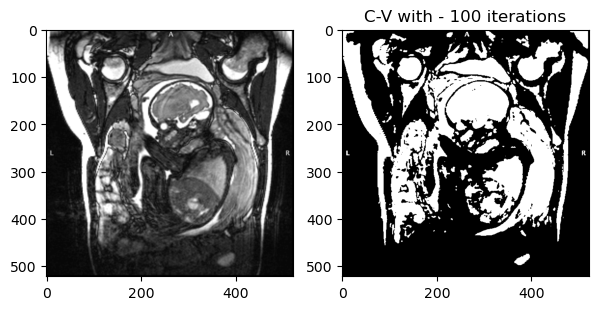

In [53]:
# PARAMETERS
mu_val = 1e-2; lambda1_val = 1; lambda2_val = 1; tol_val = 1e-5; dt_val = 0.5
smoothing_val = 1

Num_iter_cv_ori = 100
Num_iter_cv_fast = 5

CHAN_VESE_ORI = 1
Init_method = "disk"  # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)

# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper
    init_ls = checkerboard_level_set(img_to_seg.shape, 45)
    cv = chan_vese(
        img_to_seg,
        mu=mu_val,
        lambda1=lambda1_val,
        lambda2=lambda2_val,
        tol=tol_val,
        dt=dt_val,
        max_num_iter=Num_iter_cv_ori,
        init_level_set=Init_method,
        extended_output=True,
    )
    fig, ax = plt.subplots(1, 2, figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(cv[0], cmap=plt.cm.gray)
    title = f"C-V with - {len(cv[2])} iterations"
    ax[1].set_title(title, fontsize=12)
else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv = morphological_chan_vese(
        img_to_seg,
        num_iter=Num_iter_cv_fast,
        smoothing=smoothing_val,
        init_level_set="checkerboard",
    )
    fig, ax = plt.subplots(1, 2, figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(cv, cmap=plt.cm.gray)
    title = f"C-V_morph with - {Num_iter_cv_fast} iterations"
    ax[1].set_title(title, fontsize=12)

plt.show()

# Seg # 8

## Geometric active contours with balloon force

You are now also provided with a tool to track the deformation patterns of the active contour over iterations. <br>

The geometric active contour routine is **morphological_geodesic_active_contour** which deforms a level set function with local speed values. It has the following **hyper-parameters** :<br>
* `Thresh_cont_val="auto"` => `np.percentile(image, 40)` (default if 'auto')  | pixels < Thresh_cont_val are considered borders. The evolution of the contour will stop on these pixels. `Threshold_mask_balloon = image > threshold / np.abs(Balloon_weight)`
* `Balloon_weight=1` (default) | weight of the balloon force. Can be negative to inflate/deflat
* `Smooth_cont_iter=1` (default) |  Number of times a smoothing operator is applied per iteration


# TO DO:

1. Segment the `img_cell` with the provided configuration in line 1 to inflate the initial contour. What is the issue?
2. Now Segment the `img_cell` with the provided configuration in line 2 to deflate the initial contour. Adjust balloon parameter accordingly. Fix the issues observed to get a perfect segmentation in 30 iterations. 
3. Segment the `img_MRIb` image with the configuration in line 3 set to inflate an initial contour. Comment issues seen with high and low smoothness regularization over 300 iterations. 
4. Now propose and run a setup to attempt to segment the gray matter contours in `img_MRIb` or some structure in another image. Comment on your choice of parameters, number of iterations and observed quality of contours. 

## ANSWERS

**1.** Given the specified configuration, the contour initiation occurs from within the cell and expands outward until reaching its borders. However, due to the segmented object having a noisy interior and a complex texture, the algorithm encounters challenges in contour expansion, necessitating a substantial number of small steps to reach the cell's border. Despite these difficulties, the final outcome is deemed acceptable, as the cell contour is successfully outlined, capturing its irregularities.

**2.** To enhance the contour segmentation, it was essential to adjust the `Balloon_weight` parameter to `-1` for a "deflation" effect. This modification, coupled with an additional preprocessing step involving Gaussian smoothing, led to an almost perfect segmentation achieved within 30 iterations. The following hyperparameters were employed:

```
img_to_seg = img_cell; r0 = 130;  c0 = 125; R0 = 70  # deflate

SMOOTHING = 1; Niter_smooth = 2
INV_EDGE_MAP = 1 # needed when using the Balloon force

img_ori = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val = "auto"; Balloon_weight = -1; Smooth_cont_iter = 1
Niter_snake = 30
```

**3.** When the smoothness is set too low, the algorithm encounters difficulties in effectively expanding the contour. Conversely, high smoothness leads to the inclusion of undesired objects within the contour. By fine-tuning both the smoothness and the `Balloon_weight`, it becomes feasible to accurately segment the spine. The optimal configuration for achieving this segmentation is as follows:

```
img_to_seg = img_MRIb; r0 = 500; c0 = 530; R0 = 30  # for spine and inflate

SMOOTHING = 0; Niter_smooth = 0
INV_EDGE_MAP = 1 # needed when using the Balloon force

img_ori = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val = "auto"; Balloon_weight = 0.90; Smooth_cont_iter = 1
Niter_snake = 300

```

**4.** Given the intricacies of the gray matter, which boasts a complex contour, intricate interior, and exterior textures, the segmentation results are less pronounced compared to simpler images. Nevertheless, the outcomes obtained are deemed acceptable, as they manage to roughly delineate the outline of the gray matter, albeit requiring a higher number of iterations. The optimal configuration for achieving this segmentation is outlined below:

```
img_to_seg = img_MRIb; r0 = 180; c0 = 550; R0 = 40  # for gray matter

SMOOTHING = 1; Niter_smooth = 13
INV_EDGE_MAP = 1 # needed when using the Balloon force

img_ori = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val = "auto"; Balloon_weight = 1; Smooth_cont_iter = 1
Niter_snake = 350
```

0.7377611236173724


C:\Users\willf\AppData\Local\Temp\ipykernel_23084\1930474076.py:61: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour.collections[0].set_label("Contours")


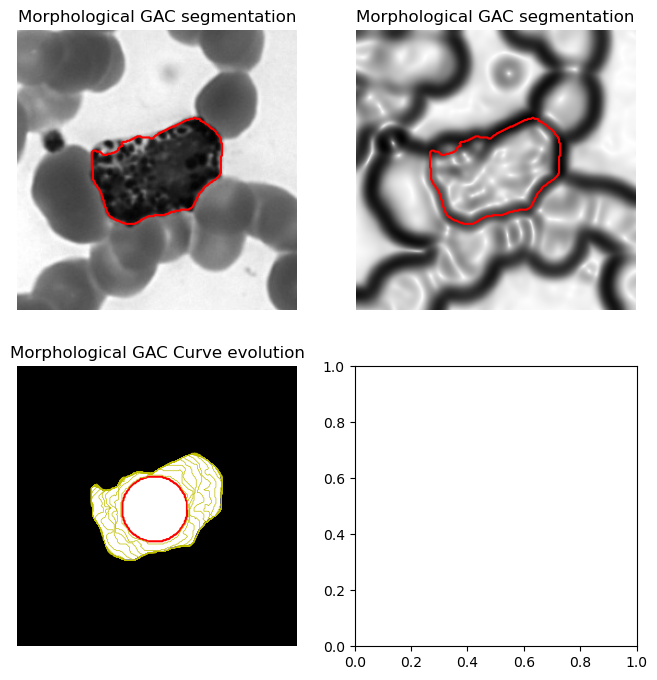

In [54]:
img_to_seg = img_cell; r0 = 130; c0 = 125; R0 = 30  # inflate

SMOOTHING = 0; Niter_smooth = 3
INV_EDGE_MAP = 1 # needed when using the Balloon force

img_ori = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val = "auto"; Balloon_weight = 1; Smooth_cont_iter = 1
Niter_snake = 100

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(
        img_to_seg
    )  # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

# Print threshold used by "auto"
print(np.percentile(img_to_seg, 40))

# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour
init_ls = skimage.segmentation.disk_level_set(
    img_to_seg.shape, center=[r0, c0], radius=R0
)

# Run geodesic active contour
ls = morphological_geodesic_active_contour(
    img_to_seg,
    Niter_snake,
    init_ls,
    smoothing=Smooth_cont_iter,
    balloon=Balloon_weight,
    threshold=Thresh_cont_val,
    iter_callback=callback,
)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(img_ori, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors="r")
ax[0].set_title("Morphological GAC segmentation", fontsize=12)

ax[1].imshow(img_to_seg, cmap="gray")
ax[1].set_axis_off()
ax[1].contour(ls, [0.5], colors="r")
ax[1].set_title("Morphological GAC segmentation", fontsize=12)

ax[2].imshow(ls, cmap="gray")
ax[2].set_axis_off()
contour = ax[2].contour(evolution[0], [0.5], colors="r")
contour.collections[0].set_label("Contours")
title = f"Morphological GAC Curve evolution"
ax[2].set_title(title, fontsize=12)
for i in range(1, Niter_snake - 1, 5):
    contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors="y")

plt.show()

0.7365700360297274


C:\Users\willf\AppData\Local\Temp\ipykernel_23084\3041647129.py:61: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour.collections[0].set_label("Contours")


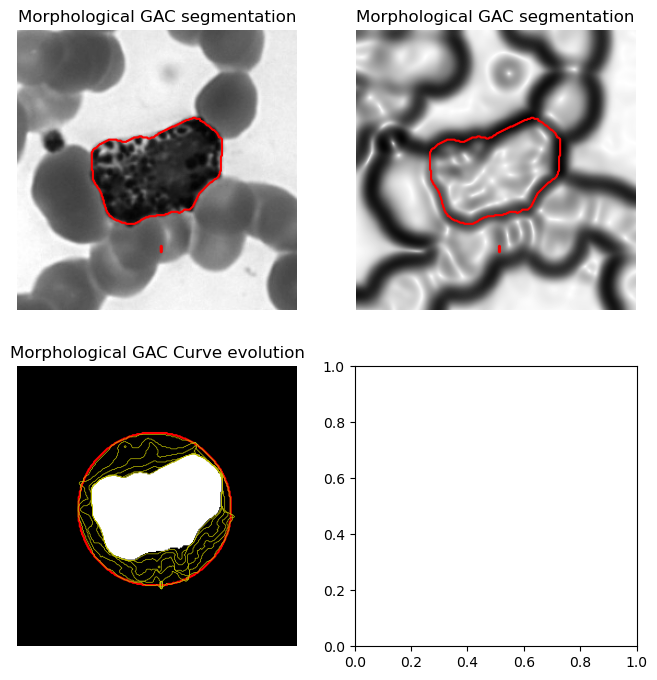

In [55]:
img_to_seg = img_cell; r0 = 130;  c0 = 125; R0 = 70  # deflate

SMOOTHING = 1; Niter_smooth = 2
INV_EDGE_MAP = 1 # needed when using the Balloon force

img_ori = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val = "auto"; Balloon_weight = -1; Smooth_cont_iter = 1
Niter_snake = 30

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(
        img_to_seg
    )  # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

# Print threshold used by "auto"
print(np.percentile(img_to_seg, 40))

# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour
init_ls = skimage.segmentation.disk_level_set(
    img_to_seg.shape, center=[r0, c0], radius=R0
)

# Run geodesic active contour
ls = morphological_geodesic_active_contour(
    img_to_seg,
    Niter_snake,
    init_ls,
    smoothing=Smooth_cont_iter,
    balloon=Balloon_weight,
    threshold=Thresh_cont_val,
    iter_callback=callback,
)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(img_ori, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors="r")
ax[0].set_title("Morphological GAC segmentation", fontsize=12)

ax[1].imshow(img_to_seg, cmap="gray")
ax[1].set_axis_off()
ax[1].contour(ls, [0.5], colors="r")
ax[1].set_title("Morphological GAC segmentation", fontsize=12)

ax[2].imshow(ls, cmap="gray")
ax[2].set_axis_off()
contour = ax[2].contour(evolution[0], [0.5], colors="r")
contour.collections[0].set_label("Contours")
title = f"Morphological GAC Curve evolution"
ax[2].set_title(title, fontsize=12)
for i in range(1, Niter_snake - 1, 5):
    contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors="y")

plt.show()

0.785146875520775


C:\Users\willf\AppData\Local\Temp\ipykernel_23084\2408205875.py:61: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour.collections[0].set_label("Contours")


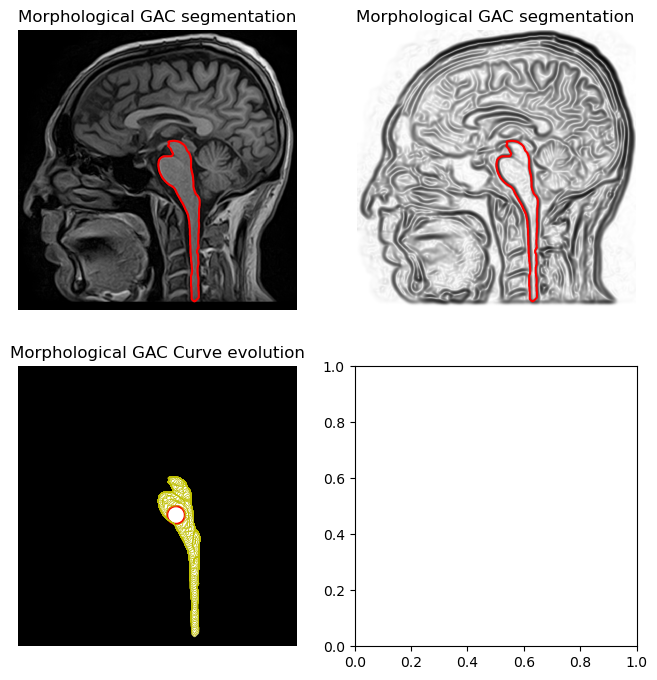

In [56]:
img_to_seg = img_MRIb; r0 = 500; c0 = 530; R0 = 30  # for spine and inflate

SMOOTHING = 0; Niter_smooth = 0
INV_EDGE_MAP = 1 # needed when using the Balloon force

img_ori = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val = "auto"; Balloon_weight = 0.90; Smooth_cont_iter = 1
Niter_snake = 300

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(
        img_to_seg
    )  # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

# Print threshold used by "auto"
print(np.percentile(img_to_seg, 40))

# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour
init_ls = skimage.segmentation.disk_level_set(
    img_to_seg.shape, center=[r0, c0], radius=R0
)

# Run geodesic active contour
ls = morphological_geodesic_active_contour(
    img_to_seg,
    Niter_snake,
    init_ls,
    smoothing=Smooth_cont_iter,
    balloon=Balloon_weight,
    threshold=Thresh_cont_val,
    iter_callback=callback,
)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(img_ori, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors="r")
ax[0].set_title("Morphological GAC segmentation", fontsize=12)

ax[1].imshow(img_to_seg, cmap="gray")
ax[1].set_axis_off()
ax[1].contour(ls, [0.5], colors="r")
ax[1].set_title("Morphological GAC segmentation", fontsize=12)

ax[2].imshow(ls, cmap="gray")
ax[2].set_axis_off()
contour = ax[2].contour(evolution[0], [0.5], colors="r")
contour.collections[0].set_label("Contours")
title = f"Morphological GAC Curve evolution"
ax[2].set_title(title, fontsize=12)
for i in range(1, Niter_snake - 1, 5):
    contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors="y")

plt.show()

0.88141104334385


C:\Users\willf\AppData\Local\Temp\ipykernel_23084\2235118754.py:61: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour.collections[0].set_label("Contours")


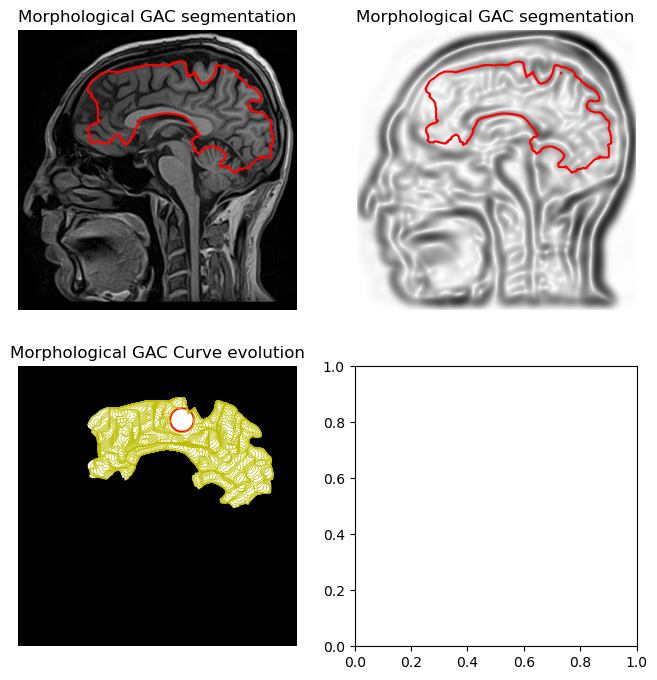

In [57]:
img_to_seg = img_MRIb; r0 = 180; c0 = 550; R0 = 40  # for gray matter

SMOOTHING = 1; Niter_smooth = 13
INV_EDGE_MAP = 1 # needed when using the Balloon force

img_ori = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val = "auto"; Balloon_weight = 1; Smooth_cont_iter = 1
Niter_snake = 350

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(
        img_to_seg
    )  # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

# Print threshold used by "auto"
print(np.percentile(img_to_seg, 40))

# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour
init_ls = skimage.segmentation.disk_level_set(
    img_to_seg.shape, center=[r0, c0], radius=R0
)

# Run geodesic active contour
ls = morphological_geodesic_active_contour(
    img_to_seg,
    Niter_snake,
    init_ls,
    smoothing=Smooth_cont_iter,
    balloon=Balloon_weight,
    threshold=Thresh_cont_val,
    iter_callback=callback,
)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(img_ori, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors="r")
ax[0].set_title("Morphological GAC segmentation", fontsize=12)

ax[1].imshow(img_to_seg, cmap="gray")
ax[1].set_axis_off()
ax[1].contour(ls, [0.5], colors="r")
ax[1].set_title("Morphological GAC segmentation", fontsize=12)

ax[2].imshow(ls, cmap="gray")
ax[2].set_axis_off()
contour = ax[2].contour(evolution[0], [0.5], colors="r")
contour.collections[0].set_label("Contours")
title = f"Morphological GAC Curve evolution"
ax[2].set_title(title, fontsize=12)
for i in range(1, Niter_snake - 1, 5):
    contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors="y")

plt.show()